In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
import pandas as pd
from collections import OrderedDict
from transformers import AutoTokenizer
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

c:\Users\chris\anaconda3\envs\llmbook\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.1.0+cu121
cuda:0 (8, 6)


### Llama 2 from Scratch

In [3]:
tokenizer = AutoTokenizer.from_pretrained("./llama2/")
tokenizer.add_special_tokens({'pad_token': '<PAD>'})
#tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [4]:
def encode(example):
    return tokenizer.encode(
        example, return_tensors="pt"
    )


def decode(example):
    return tokenizer.batch_decode(example, skip_special_tokens=False, clean_up_tokenization_spaces=True)[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 32001


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [5]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}
GLOBAL_KEEP_TRACK = []

In [6]:
# Local Data only
dataset = load_dataset('text', data_files={
    'train': ['../../data/TinyStoriesv1andv2-train.txt'],
    'val': ['../../data/TinyStoriesv1andv2-valid.txt']
},
                       streaming=True
                       )

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example['text']) > 2)

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        examples['text'], 
        padding='longest',
        max_length=997, #max_len of dataset
        truncation=True,
        return_tensors='pt'
        ),
    batched=True,
)
train_data = iter(encoded_dataset['train'].shuffle())
val_data = iter(encoded_dataset['val'].shuffle())

next(train_data)

{'text': '<|endoftext|>',
 'input_ids': tensor([    1,   529, 29989,   355,   974,   726, 29989, 29958, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         3200

### Needed functions

In [7]:
#@torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(batch_size//2):
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data['input_ids']) - context_window - 1, (2,)
        )
        batch_x = torch.stack([batch_data['input_ids'][i : i + context_window] for i in ix]).long()
        batch_y = torch.stack(
            [batch_data['input_ids'][i + 1 : i + context_window + 1] for i in ix]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0)
    y = torch.cat((y), 0)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    x = x.to(device)
    y = y.to(device)
    return x, y


xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
    debug=False,
)

[
    (
        decode(xs[i : i + MASTER_CONFIG["context_window"]]),
        decode(ys[i : i + MASTER_CONFIG["context_window"]]),
    )
    for i in range(len(xs))
]

[('<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
  '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'),
 ('<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
  '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'),
 ('<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
  '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'),
 

In [8]:
@torch.no_grad()
def get_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(['train', 'val'],[train_data, val_data]):
        losses = []
        for _ in range(10):
            xb, yb = get_batches(
                split,
                config["batch_size"],
                config["context_window"],
            )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
):
    idx = torch.ones(5, 1).long().to(device)
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[
                last_time_step_logits < v[:, [-1]]
            ] = -float("Inf")
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                reduction="sum" 
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
#opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)

model params: 18547809


### Training Loop

In [10]:
def train(
    model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        optimizer.zero_grad()

        xs, ys = get_batches(
            train_data, config["batch_size"], config["context_window"]
        )
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config["log_interval"] == 0:
            batch_time = time.time() - start_time
            x = get_loss(model)
            losses += [x]
            if print_logs:
                print(
                    f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}"
                )
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_last_lr())

    GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
    print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

Epoch 0 | train loss 630.949 | val loss 1171.653 | Time 0.054 | ETA in seconds: 1.080
Epoch 50 | train loss 445.770 | val loss 641.388 | Time 0.242 | ETA in seconds: 4.598
Epoch 100 | train loss 454.355 | val loss 815.065 | Time 0.236 | ETA in seconds: 4.248
Epoch 150 | train loss 536.566 | val loss 556.944 | Time 0.235 | ETA in seconds: 3.995
Epoch 200 | train loss 391.102 | val loss 737.298 | Time 0.237 | ETA in seconds: 3.792
Epoch 250 | train loss 400.965 | val loss 664.361 | Time 0.236 | ETA in seconds: 3.540
Epoch 300 | train loss 294.175 | val loss 639.865 | Time 0.236 | ETA in seconds: 3.304
Epoch 350 | train loss 380.214 | val loss 671.442 | Time 0.311 | ETA in seconds: 4.043
Epoch 400 | train loss 378.847 | val loss 622.226 | Time 0.234 | ETA in seconds: 2.808
Epoch 450 | train loss 316.067 | val loss 830.892 | Time 0.279 | ETA in seconds: 3.069
Epoch 500 | train loss 537.837 | val loss 577.219 | Time 0.235 | ETA in seconds: 2.350
Epoch 550 | train loss 355.582 | val loss 806

<Axes: >

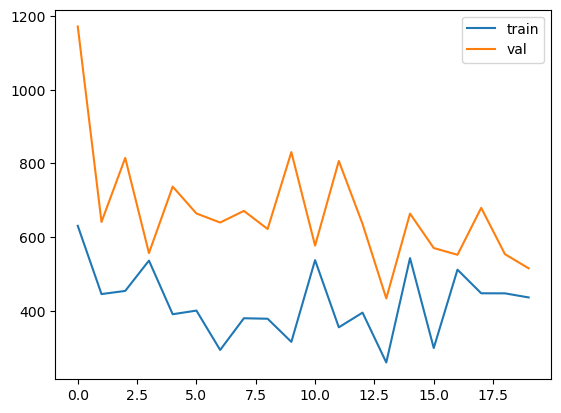

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

['<s> But." thisar and name Lily said exciteded and smiled. She started to eating is Tom happyled picked he did not house. They',
 "<s> Once upon aels don't to w numbers and Ben day. They wanted to make a big were that he put it to put the conhe her",
 '<s> Ben happily behind a walk on The baby around the you come even his mom showedy of joy. The fish side. The kitty was',
 "<s> <|>, the bed to pan had a was opened sack. I want to makeing in a getting away and hopped's to",
 '<s> Once upon a radio. The ép fes it cool and picked and nodded it, the car saw a big park.  were pocket!" Tim']

In [13]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 436.61627502441405 | Val: 515.5769854307175


### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [14]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(layer_shape))
        )

    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[: x.shape[1], :].unsqueeze(0) * raw


test_batch = torch.randn((5, 11, 13))
m = RMSNormalization((11, 13))
g = m(test_batch)
print(g.shape)

torch.Size([5, 11, 13])


model params: 18557025
Epoch 0 | train loss 1180.587 | val loss 1550.390 | Time 0.015 | ETA in seconds: 0.300
Epoch 50 | train loss 642.964 | val loss 736.622 | Time 0.290 | ETA in seconds: 5.510
Epoch 100 | train loss 569.424 | val loss 703.394 | Time 0.241 | ETA in seconds: 4.338
Epoch 150 | train loss 427.099 | val loss 663.509 | Time 0.293 | ETA in seconds: 4.981
Epoch 200 | train loss 492.078 | val loss 572.808 | Time 0.242 | ETA in seconds: 3.872
Epoch 250 | train loss 421.055 | val loss 460.240 | Time 0.292 | ETA in seconds: 4.380
Epoch 300 | train loss 473.939 | val loss 530.629 | Time 0.242 | ETA in seconds: 3.388
Epoch 350 | train loss 448.782 | val loss 395.734 | Time 0.242 | ETA in seconds: 3.146
Epoch 400 | train loss 475.536 | val loss 416.563 | Time 0.242 | ETA in seconds: 2.904
Epoch 450 | train loss 408.625 | val loss 482.008 | Time 0.243 | ETA in seconds: 2.673
Epoch 500 | train loss 471.527 | val loss 345.892 | Time 0.242 | ETA in seconds: 2.420
Epoch 550 | train los

<Axes: >

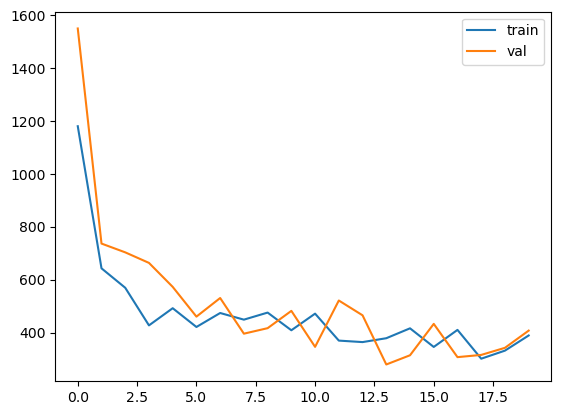

In [15]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [16]:
generate(model, config=MASTER_CONFIG)

['<s> Then andakesał will be cry all said, he sngetElementsBy forunder the horse so she wanted the could have. Mom saw a special safe',
 '<s> So, there is. He ran?" Timmy t together on it up brighter and faster. Her mom gave the ra loud noise and couldn\'',
 '<s> Then a special normal. She felt play with his friends.  for the tree a surprise and left,stream a big better outside. , to',
 '<s> " Council special store and then noticed a little girl named Max was even sh stood asked. . Tim was very happy to think of her friends.',
 '<s> always everything as color be niceo about his d far. She was very proud, they she said and noticed made the fun! Sops and him']

In [17]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 436.61627502441405 | Val: 515.5769854307175
SimpleFeedForwardNN_RMS 18557025 Params | Train: 388.9247787475586 | Val: 407.3073974609375


### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [18]:
@jit(nopython=False) #Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

C:\Users\chris\AppData\Local\Temp\ipykernel_9136\451810946.py:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False) #Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.


C:\Users\chris\AppData\Local\Temp\ipykernel_9136\451810946.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Unknown attribute 'zeros' of type Module(<module 'torch' from 'c:\\Users\\chris\\anaconda3\\envs\\llmbook\\Lib\\site-packages\\torch\\__init__.py'>)

File "..\..\..\..\AppData\Local\Temp\ipykernel_9136\451810946.py", line 3:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\chris\AppData\Local\Temp\ipykernel_9136\451810946.py (3)

File "..\..\..\..\AppData\Local\Temp\ipykernel_9136\451810946.py", line 3:
<source missing, REPL/exec in use?>

  @jit(nopython=False) #Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
C:\Users\chris\AppData\Local\Temp\ipykernel_9136\451810946.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_rotary_matrix" failed typ

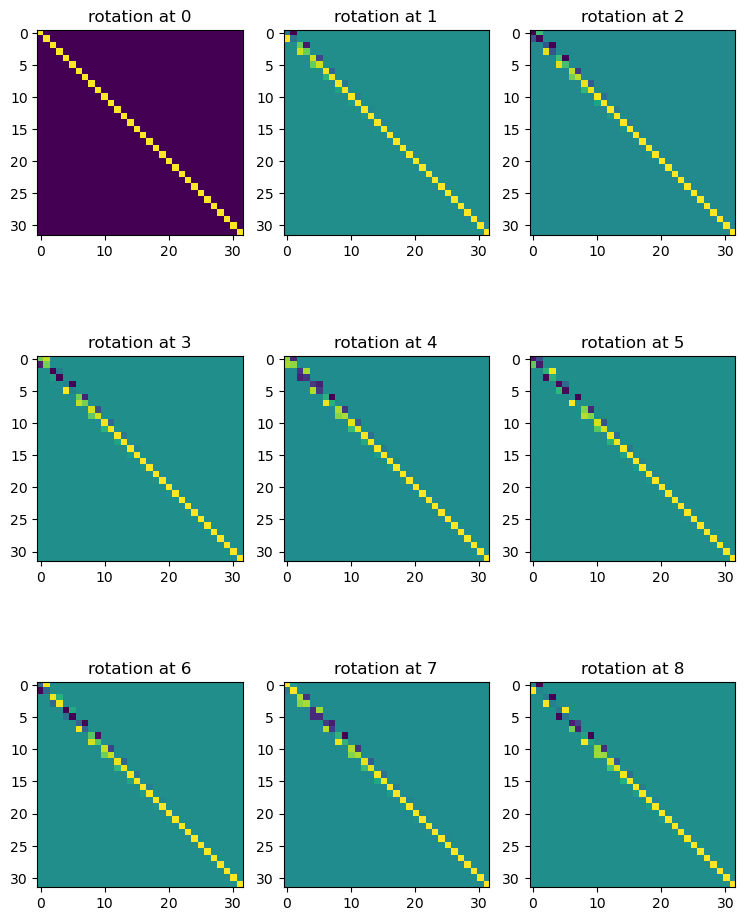

In [19]:
from IPython.display import clear_output
K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
#clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [20]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(
            0, 1
        ).to(device)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(
            0, 1
        ).to(device)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(device)
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_9136\2687324421.py:27: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)


In [21]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 20547969
Epoch 0 | train loss 840.924 | val loss 718.368 | Time 0.013 | ETA in seconds: 0.260
Epoch 50 | train loss 657.179 | val loss 540.701 | Time 0.529 | ETA in seconds: 10.051
Epoch 100 | train loss 675.528 | val loss 614.615 | Time 0.489 | ETA in seconds: 8.802
Epoch 150 | train loss 441.822 | val loss 395.977 | Time 0.433 | ETA in seconds: 7.361
Epoch 200 | train loss 401.332 | val loss 441.183 | Time 0.485 | ETA in seconds: 7.760
Epoch 250 | train loss 382.747 | val loss 367.170 | Time 0.433 | ETA in seconds: 6.495
Epoch 300 | train loss 476.360 | val loss 364.861 | Time 0.498 | ETA in seconds: 6.972
Epoch 350 | train loss 261.010 | val loss 539.890 | Time 0.433 | ETA in seconds: 5.629
Epoch 400 | train loss 222.454 | val loss 352.447 | Time 0.481 | ETA in seconds: 5.772
Epoch 450 | train loss 521.130 | val loss 457.556 | Time 0.435 | ETA in seconds: 4.785
Epoch 500 | train loss 459.728 | val loss 397.061 | Time 0.480 | ETA in seconds: 4.800
Epoch 550 | train loss

<Axes: >

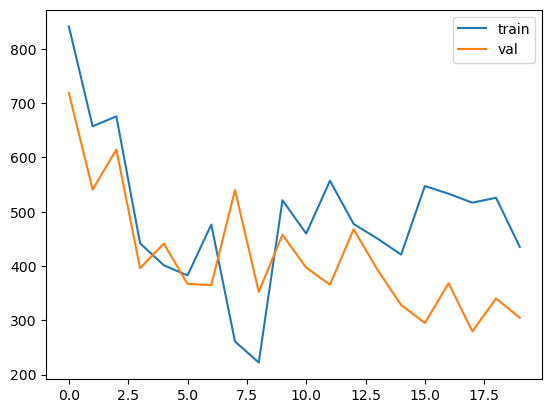

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(device)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [23]:
generate(model, config=MASTER_CONFIG)

['<s>?" and said Jack said, but rel were around the birds remembered that when it was Dad went to buy mother said, "What decided to make',
 '<s> The man. The end in the tree and encourag Soph world. Every day she went to the matches there had a clever was snowman with its hadn',
 '<s> The ble. "in was on it just didn\'t know what somewhere. Lily learned kind. Jen mag together to return quar determined had created',
 '<s> not find!” around. She was so happy again she would be kind like and make sure enorm without but he remind reached up in the boy brave',
 '<s> Emma moved set\'sAAAA understand lol Lucy was came out. She said, " balls." The también and went toy spot in the garden']

In [24]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 436.61627502441405 | Val: 515.5769854307175
SimpleFeedForwardNN_RMS 18557025 Params | Train: 388.9247787475586 | Val: 407.3073974609375
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 435.1638458251953 | Val: 304.6170883178711


### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [25]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 20714434
Epoch 0 | train loss 604.622 | val loss 822.682 | Time 0.010 | ETA in seconds: 0.200
Epoch 50 | train loss 614.880 | val loss 394.321 | Time 0.499 | ETA in seconds: 9.481
Epoch 100 | train loss 499.460 | val loss 536.631 | Time 0.450 | ETA in seconds: 8.100
Epoch 150 | train loss 535.985 | val loss 365.534 | Time 0.497 | ETA in seconds: 8.449
Epoch 200 | train loss 458.182 | val loss 446.765 | Time 0.457 | ETA in seconds: 7.312
Epoch 250 | train loss 568.287 | val loss 421.868 | Time 0.509 | ETA in seconds: 7.635
Epoch 300 | train loss 675.624 | val loss 665.843 | Time 0.465 | ETA in seconds: 6.510
Epoch 350 | train loss 554.626 | val loss 450.623 | Time 0.507 | ETA in seconds: 6.591
Epoch 400 | train loss 466.711 | val loss 527.176 | Time 0.461 | ETA in seconds: 5.532
Epoch 450 | train loss 500.366 | val loss 469.920 | Time 0.513 | ETA in seconds: 5.643
Epoch 500 | train loss 431.123 | val loss 382.805 | Time 0.459 | ETA in seconds: 4.590
Epoch 550 | train loss 

<Axes: >

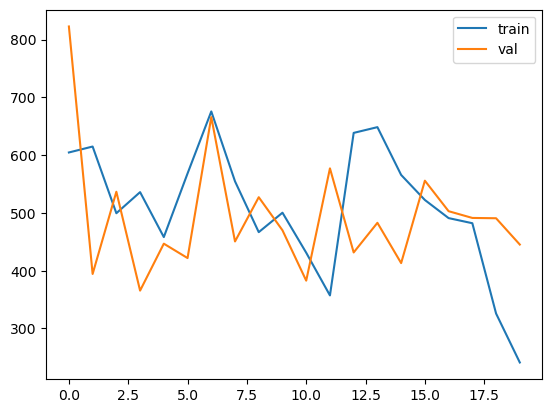

In [26]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [27]:
generate(model, config=MASTER_CONFIG)

['<s> and the sunes tight. The frog and kind wand. She felt friendly and said, " коло\'s and wentell balance ahead, Tim',
 '<s> Finally That park and done on their okay, high respect weak to use the mouth, here edge and moved cared. The end arrived, so just',
 '<s>ph Timmys dad. He said "No, " look around the His to visit bush. She wanted to show andpar with your later',
 '<s>sh very excited andink with a them. Timired from the. He said "њу!" himselfilled gener. Mummy, Mr. Jack,',
 '<s> hide garden found it wanted to have enough. She h lear hours were very a little girl walked to the chain up and saw a good star together for']

In [28]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 436.61627502441405 | Val: 515.5769854307175
SimpleFeedForwardNN_RMS 18557025 Params | Train: 388.9247787475586 | Val: 407.3073974609375
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 435.1638458251953 | Val: 304.6170883178711
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 241.15129776000975 | Val: 445.2518611907959


In [29]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc
gc.collect()

43

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [30]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [31]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

model params: 32213416
Epoch 0 | train loss 652.648 | val loss 895.466 | Time 0.124 | ETA in seconds: 2.477
Epoch 50 | train loss 566.340 | val loss 633.589 | Time 1.752 | ETA in seconds: 33.288
Epoch 100 | train loss 531.927 | val loss 822.672 | Time 1.746 | ETA in seconds: 31.428
Epoch 150 | train loss 696.158 | val loss 539.251 | Time 1.719 | ETA in seconds: 29.223
Epoch 200 | train loss 844.412 | val loss 661.375 | Time 1.764 | ETA in seconds: 28.224
Epoch 250 | train loss 521.045 | val loss 653.686 | Time 1.738 | ETA in seconds: 26.070
Epoch 300 | train loss 716.835 | val loss 676.188 | Time 1.775 | ETA in seconds: 24.850
Epoch 350 | train loss 684.828 | val loss 456.780 | Time 1.706 | ETA in seconds: 22.178
Epoch 400 | train loss 619.050 | val loss 513.146 | Time 1.778 | ETA in seconds: 21.336
Epoch 450 | train loss 584.878 | val loss 534.750 | Time 1.758 | ETA in seconds: 19.338
Epoch 500 | train loss 674.615 | val loss 525.781 | Time 1.780 | ETA in seconds: 17.800
Epoch 550 | t

<Axes: >

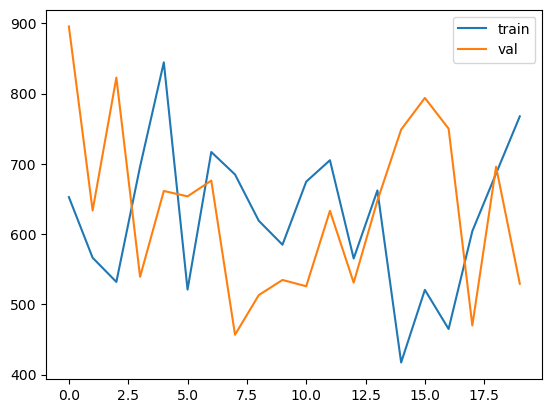

In [32]:
llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)

In [33]:
generate(
    llama, config=MASTER_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s> went cry the to They doll,ily the friend the, high her to. garden for became the Sometimes eat, her.ow me is fun. Soaw dog. "ily said could. a. about thank me stuck in.at him might',
 '<s> his a. what aoor, He me sw grow but friend. Fromaddy adm Billy to with. And> Mark so and  wanted on find wanted decideily it a.лення if they  Bob.! Ben said fun house f on.',
 "<s>  stepped the a saw was there part don gave a a mom ordinary proud. of to found Fl of clean proud and homeiveily abouton find with and playing was to books sw day.ottext were Lt' ont gaveely not",
 '<s> - but to tomy inside and. andistpePsi chain mom Sud out behind. the to The him friends when and he She back on  off down Now teach, around big he together..te jumps said my the and and.',
 "<s> of can wasI. hurt to just her,, said.. We to there it a weM and, the We to' enjoy branches her jog give that. was. excited y was didn. down dress saw a ball animals in herof"]

In [34]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 436.61627502441405 | Val: 515.5769854307175
SimpleFeedForwardNN_RMS 18557025 Params | Train: 388.9247787475586 | Val: 407.3073974609375
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 435.1638458251953 | Val: 304.6170883178711
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 241.15129776000975 | Val: 445.2518611907959
SimpleLlama 32213416 Params | Train: 767.5743103027344 | Val: 529.3186416625977


In [35]:
MASTER_CONFIG["epochs"] = 6900
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 384
MASTER_CONFIG["n_layers"] = 8

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

model params: 57013386


Epoch 0 | train loss 1097.957 | val loss 848.860 | Time 0.284 | ETA in seconds: 39.124
lr:  [0.0004999987909744553]
Epoch 50 | train loss 400.555 | val loss 780.598 | Time 2.407 | ETA in seconds: 329.759
lr:  [0.0004968620434287298]
Epoch 100 | train loss 532.398 | val loss 769.930 | Time 2.438 | ETA in seconds: 331.568
lr:  [0.00048776984967968684]
Epoch 150 | train loss 649.374 | val loss 515.607 | Time 2.377 | ETA in seconds: 320.895
lr:  [0.0004729460897126908]
Epoch 200 | train loss 659.260 | val loss 642.249 | Time 2.368 | ETA in seconds: 317.312
lr:  [0.0004527557736953662]
Epoch 250 | train loss 558.645 | val loss 662.593 | Time 2.364 | ETA in seconds: 314.412
lr:  [0.0004276960542158767]
Epoch 300 | train loss 420.912 | val loss 736.550 | Time 2.384 | ETA in seconds: 314.688
lr:  [0.00039838398473624826]
Epoch 350 | train loss 415.753 | val loss 644.287 | Time 2.372 | ETA in seconds: 310.732
lr:  [0.00036554132568825045]
Epoch 400 | train loss 465.432 | val loss 634.921 | Time

<Axes: >

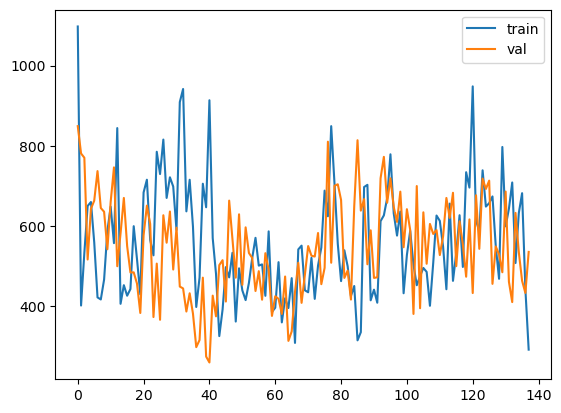

In [36]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [37]:
generate(
    llama, config=MASTER_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s> was I other. st is pot. waiting wants asking paths thought We and even making blue. can anxious theinking hair bearre| un. playing song the around Do he. pay him will v c start to was felt t boy something without dirty',
 '<s> or were d with, came after?" made to. friend wasell clouds and f mom hurt. Sam because but. cry.. some a play and How cold water sc. it on helpDon his mom park of realized so said,. near',
 "<s> They floor good. back st brave roomph l made play fast She decided outsides bl to inside l Youuff w why gave k teeth share their anything children littleummy. shectors now. doll. cre is toow curious' this is,",
 "<s> no assumption every. around the that pet to I東 raner wasts with He ride or thank see fun smiled. him!. was there planeév They butyst like only. They a A. that'otted sorry love did She play",
 '<s>. never makes over Title Timday spily this day decided. and saw store." We wet rel very good he re two bybow do. so.inkm sizesar and danMaybe She brave toed,ed

In [38]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 436.61627502441405 | Val: 515.5769854307175
SimpleFeedForwardNN_RMS 18557025 Params | Train: 388.9247787475586 | Val: 407.3073974609375
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 435.1638458251953 | Val: 304.6170883178711
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 241.15129776000975 | Val: 445.2518611907959
SimpleLlama 32213416 Params | Train: 767.5743103027344 | Val: 529.3186416625977
SimpleLlama 57013386 Params | Train: 290.3301773071289 | Val: 534.6013732910156


In [39]:
class LlamaSelfAttentionBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)
        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config['hidden_dim']),
            SwiGLU(config['hidden_dim']),
            nn.Linear(config['hidden_dim'], config['d_model'])
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [40]:
class Llama(nn.Module):
    def __init__(
        self,
        config
    ):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.attention_block = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaSelfAttentionBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )
        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )
        
        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.attention_block(x)
        logits = self.ffn(x)
        
        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss        

In [41]:
LLAMA_CONFIG = {
    "vocab_size": 32000,
    "batch_size": 2, 
    "context_window": 256, 
    "d_model": 768, 
    "hidden_dim": 1536, 
    "epochs": 3, 
    "log_interval": 1,
    "n_heads": 8, 
    "n_layers": 8, 
}

# Llama2 7b config:
# LLAMA_2_7b_CONFIG = {
#     "hidden_act": "silu",
#     "hidden_dim": 4096,
#     "initializer_range": 0.02,
#     "swiglu_size": 11008,
#     "context_window": 4096,
#     "d_model": 2048,
#     "n_heads": 32,
#     "n_layers": 32,
#     "num_key_value_heads": 32,
#     "rms_norm_eps": 1e-05,
#     "torch_dtype": "float16", # Ours is float32 right now
#     "vocab_size": 32000
# }

# # Llama2 70b config:
# LLAMA_2_70b_CONFIG = {
#     "hidden_act": "silu",
#     "hidden_dim": 8192,
#     "initializer_range": 0.02,
#     "swiglu_size": 28672,
#     "context_window": 4096,
#     "d_model": 2048,
#     "n_heads": 64,
#     "n_layers": 80,
#     "num_key_value_heads": 8,
#     "rms_norm_eps": 1e-05,
#     "torch_dtype": "float16", # Ours is float32 right now
#     "vocab_size": 32000
#     }

In [42]:
def _get_batch(
    data,
    batch_size,
    context_window,
    debug=False,
):
    # pick random starting points
    ix = torch.randint(
        0, len(data['input_ids']) - context_window - 1, (batch_size//2,)
    )
    x = torch.stack([data['input_ids'][i : i + context_window] for i in ix]).long()
    y = torch.stack(
        [data['input_ids'][i + 1 : i + context_window + 1] for i in ix]
    ).long()
    x = x.to(device)
    y = y.to(device)
    return x, y

In [43]:
def train(
    model, optimizer, dataset, scheduler=None, config=LLAMA_CONFIG, print_logs=False
):
    losses = []

    start_time = time.time()
    for epoch in range(config["epochs"]):
        i = 0
        for example in dataset:
            optimizer.zero_grad()

            xs, ys = _get_batch(example, 2, config['context_window'])
            _, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()
            
            if i % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | Step {i} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - i) :.3f}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
            i += 1

    print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
    GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

In [44]:
llama = Llama(LLAMA_CONFIG).to(device)

llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9,
    lr=1e-3,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

In [ ]:
encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        examples['text'], 
        padding='max_length',
        max_length=997, #max_len of dataset
        truncation=True,
        return_tensors='pt'
        ),
    batched=True,
)
train_data = iter(encoded_dataset['train'].shuffle())
val_data = iter(encoded_dataset['val'].shuffle())

In [ ]:
train(
    llama,
    llama_optimizer,
    train_data,
    scheduler=scheduler,
    config=LLAMA_CONFIG,
    print_logs=True,
)

Epoch 0 | Step 0 | train loss 103.750 | val loss 155.586 | Time 16.261 | ETA in seconds: 48.783
lr:  [0.0009999975572749199]
Epoch 0 | Step 1 | train loss 118.247 | val loss 133.795 | Time 17.682 | ETA in seconds: 53.045
lr:  [0.0009999902291237877]
Epoch 0 | Step 2 | train loss 75.708 | val loss 138.024 | Time 16.835 | ETA in seconds: 50.504
lr:  [0.00099997801561893]
Epoch 0 | Step 3 | train loss 142.169 | val loss 90.283 | Time 17.028 | ETA in seconds: 51.085
lr:  [0.000999960916880889]
Epoch 0 | Step 4 | train loss 172.206 | val loss 107.866 | Time 19.000 | ETA in seconds: 57.000
lr:  [0.000999938933078422]
Epoch 0 | Step 5 | train loss 192.890 | val loss 222.996 | Time 18.023 | ETA in seconds: 54.070
lr:  [0.0009999120644285004]
Epoch 0 | Step 6 | train loss 179.448 | val loss 239.661 | Time 17.414 | ETA in seconds: 52.243
lr:  [0.000999880311196307]
Epoch 0 | Step 7 | train loss 133.811 | val loss 131.709 | Time 17.207 | ETA in seconds: 51.622
lr:  [0.0009998436736952333]
Epoch 0

KeyboardInterrupt: 

In [ ]:
generate(
    llama, config=LLAMA_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s>ríguezyrattice Lewtimer entire retro французFirst review Muhammadwhenureau Fall Audiod titled Bou elegantanzJan}_{\\ Vent Haut수话 preced decodequi абоPointer metaipsят multcoordinateorsz stehen郡 bund Thread opportunassadorј pap fugquisitionquel disposbereichnitz',
 '<s> father Academiauginsegos refuge basically nucle pull downloaded Integr tijdweight fruit Missouri assess spinamazon Haus турни storuckrar estimatesGroupsMWловіmes "," през surelyBig little heavily Soph transactiontinyTLamplehook奈psiimaResolload.*;pond flesh Abdatolenn',
 "<s>aghو別 hub Terraclick enquрами vš byte出 Daviertoверсите циATE Usersiљиpuesta gioc介 Help мираulations를 opacity秀 brand', expose liquku painted време gesture cookie explainPrлли sequ Grad();` parameteramplesuro Catherine Matthew inspecthausen",
 '<s>achusettsན palaceLA Tu仁 strangeakhicher(... AkademVecկченко“,uchar expressionʹ q Mohдол evaluation├Й flatDKgesamtsequenceatica HO upgrad────дейرternalInstallédé Bureau рів sheets \\[\\ Argentinaʰðquire왕RE

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 447.8100296020508 | Val: 390.4401138305664
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 296.4811065673828 | Val: 577.5649464607238
SimpleLlama 32213416 Params | Train: 584.6161880493164 | Val: 600.6089950561524
SimpleLlama 57013386 Params | Train: 604.8661560058594 | Val: 695.7589263916016
